# Airtime Assignment

The following analysis aims at measuring user engagement with the Airtime application. The data is for a given day, which user id has entered a particular room at a given time. The goal is to analyze level of User Engagement with the application for the given day.

To investigate this data, we will first import required libraries, and load the dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid", font_scale=1)
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format ='retina'
plt.style.use('ggplot')
import datetime as dt
from sklearn.metrics import confusion_matrix
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
from wordcloud import WordCloud

In [2]:
# So that we can look at full data, its better to set the viewing options.

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth',-1)

In [3]:
user_room_data=pd.read_csv('room_entries.csv')
user_room_data.shape

(274636, 4)

To get an idea of the dataset, it makes sense to visualize few rows.

In [4]:
user_room_data.head(10);

The above dataset has 4 columns; 

* timestamp(time of user entering a room),

* user(user id),

* room(room id), and 

* room_name (name of the party room the user has entered).

## Data Exploration

### Handle Missing Values and Inspect Data Types


It is worthwhile checking for missing values as well as datatypes of the different columns in the dataset. Missing values, depending on the problem posed, are handled differently for different cases. As a quick check, we see that there are no missing values in this data.  

In [5]:
for i in user_room_data.columns:
    sum(pd.isna(user_room_data[i]));

In [6]:
user_room_data.dtypes

timestamp    int64 
user         object
room         object
room_name    object
dtype: object

### Basic Feature Extraction

Since we are lookng for user engagement with App for a given day, it will be useful to extract time informtaion from the timestamp column.

In [7]:
user_room_data['time']=user_room_data['timestamp'].apply(lambda x:pd.Timestamp(x,unit='s',tz='US/Pacific'))

In [8]:
user_room_data['date']=user_room_data['time'].dt.date
user_room_data['weekday']= user_room_data['time'].dt.weekday
user_room_data['hour']= user_room_data['time'].dt.hour


In [9]:
user_room_data[['timestamp','time','date','weekday','hour']].head(4)

,timestamp,time,date,weekday,hour
0,1517115600,2018-01-27 21:00:00-08:00,2018-01-27,5,21
1,1517115600,2018-01-27 21:00:00-08:00,2018-01-27,5,21
2,1517115601,2018-01-27 21:00:01-08:00,2018-01-27,5,21
3,1517115601,2018-01-27 21:00:01-08:00,2018-01-27,5,21


In [10]:
#name the weekdays, and identify the duration of the day.Note that weekstarts at Monday(0), and Sunday(6).

user_room_data['week_day']=user_room_data['weekday'].\
                           apply(lambda x: 'Sat' if (x == 5) \
                                 else 'Sun')
user_room_data['Day_Duration']=user_room_data['hour'].\
                             apply(lambda x: 'Morning' \
                            if (x < 12 and x > 3)\
                            else('Noon' if (x>12 and x<16) \
                            else('Evening' if (x>16 and x<20)\
                            else 'Night')))
user_room_data.head(4);


## Short Questions

1. Which room had the most number of Distinct people entering it? 

In [11]:
popular_room = pysqldf("SELECT room_name, COUNT(DISTINCT user) AS user_cnt \
                       FROM user_room_data \
                       GROUP BY room_name \
                       ORDER BY user_cnt DESC LIMIT 1;")
popular_room;

2. Calculate mean number of room entries per user over the day. 

In [12]:
usr_room_cnt = pysqldf("SELECT AVG(room_cnt)\
                        FROM (SELECT user, COUNT(room) AS room_cnt \
                        FROM user_room_data \
                        GROUP BY user) AS tab;")
usr_room_cnt;

On an average one user has entered 7 rooms over the course of the day. While performing this calculation, every entry of a user to a room has been counted. We have ignored the case that one user can enter same room multiple times. A user entering the same user multiple times is a good sign in terms of increase in user activity.

3. How many users went in at least 3 different rooms?

In [13]:
usr_room3_cnt = pysqldf("SELECT COUNT(user) AS user_cnt \
                        FROM (SELECT user, \
                        COUNT(DISTINCT room) AS room_cnt \
                        FROM user_room_data \
                        GROUP BY user \
                        HAVING COUNT(DISTINCT room) >=3) AS tab;")
usr_room3_cnt

,user_cnt
0,9947


4. How many rooms were entered by at least 2 people in at least 12 distinct hours of the day? This problem will be solved in following steps;

  - First, we will compute for a given combination of room and hour, how many distinct users entered that room. 
  - Second  we will filter above data for only those rows where number of disinct users is at least 2.
  - Third, for evey room, we will count the number of hours for which at least two different users logged into the room. To finish, we will inlcude only those rooms where the count of hours is at least 12. 

In [14]:
room_hr_2users = pysqldf(
    "SELECT room_name,hour,COUNT(DISTINCT user) AS usr_cnt \
                        FROM user_room_data \
                        GROUP BY room_name, hour \
                        HAVING COUNT(DISTINCT user) >=2;")

The dataset, `room_hr_2users` contains the name of the `room`, and `hour` which have at least two distinct visitors. Next we will filter for those rooms who have at least two visitors for at least 12 distinct hours of the day.

In [15]:
room_hr_cnt_12 = pysqldf("SELECT COUNT(room_name) FROM \
                         (SELECT room_name, COUNT(hour) AS hour_cnt \
                         FROM room_hr_2users \
                         GROUP BY room_name \
                         HAVING COUNT(hour) >= 12) AS tab1;")
room_hr_cnt_12

,COUNT(room_name)
0,263


## Further Data Exploration


Now we will dig deeper into the data to find some more insights from the data. Keeping in mind the objective and constraints, we will focus on two things; User Engagement, and Room Characteristics. It should be noted that User Engagement is the primary objective, and Room characteristics will be used to identify level of User Engagement.


### User Engagement

We will begin from the user's perspective. User Engagement is a primary goal for the social networking Apps. There are several ways to measure User Engagement. For the following assignment, we will begin with answering some basic questions; 

* How many distinct users are intercating with the App on a given day?
* Do the users have a time preference for interacing with the App?

To answer the first question, we can look at the distribution of number of rooms entered by a user. The skewness of the distribution will tell us whether more users frequenet various party rooms or not.

In [16]:
#It is useful to get unique count of users in the dataset

unique_user_cnt = user_room_data['user'].nunique()
unique_user_cnt

39860

We see that there are close to `40K` unique users, who have visited the App within the given time interval. Next, to determine more details about user interaction, it makes sense to check whether the users are entering various distinct rooms. We can look at the distribution to determine whether more users are interested in visiting several distinct rooms.

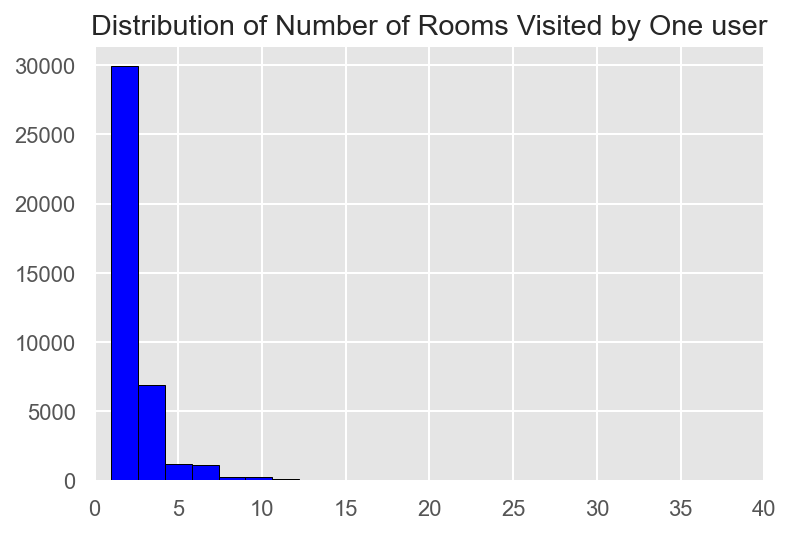

In [17]:
user_room_cnt = pysqldf("SELECT user, COUNT(DISTINCT room) AS room_cnt \
                      FROM user_room_data \
                      GROUP BY user;")
plt.hist(user_room_cnt['room_cnt'], edgecolor='Black', color='blue', bins=30)
plt.title("Distribution of Number of Rooms Visited by One user")
plt.xlim(0, 40)
plt.show()

The distribution is highly right skewed, indicating that there are very few users who have logged into more than 5 distinct rooms over the entire course of the day. 

Next it will be interesting to see the hourly variation of user percentage. This will help us to answer the question, whether users prefer particulr times to use the App. 

#### Hourly Variation of User Visits


In [18]:
hour_user_cnt = pysqldf("SELECT hour, COUNT(DISTINCT user) AS user_cnt\
                        FROM user_room_data \
                        GROUP BY hour;")
hour_user_cnt['user_pct'] = ((hour_user_cnt['user_cnt'] / 40000) *
                             100).round(2)
hour_user_cnt

,hour,user_cnt,user_pct
0,0,5422,13.56
1,1,6539,16.35
2,2,5071,12.68
3,3,3548,8.87
4,4,2315,5.79
5,5,1456,3.64
6,6,1057,2.64
7,7,823,2.06
8,8,765,1.91
9,9,900,2.25


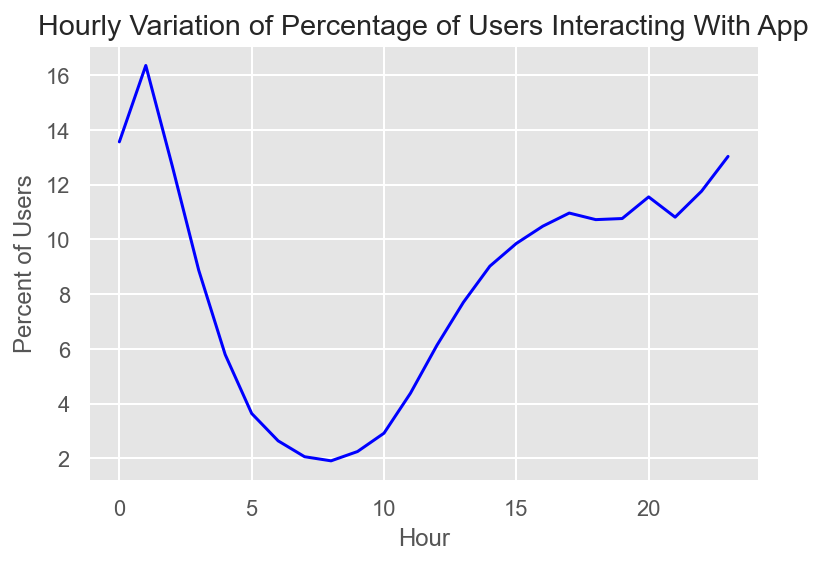

In [19]:
fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(hour_user_cnt['hour'], hour_user_cnt['user_pct'], color='blue')
plt.title("Hourly Variation of Percentage of Users Interacting With App")
plt.xlabel("Hour")
plt.ylabel("Percent of Users")
plt.show()

Going by the above line chart, it is obvious that a significant percentage of users tend to interact the App, during evening or late night. This is also evident from the following barchart, which is more condensed.

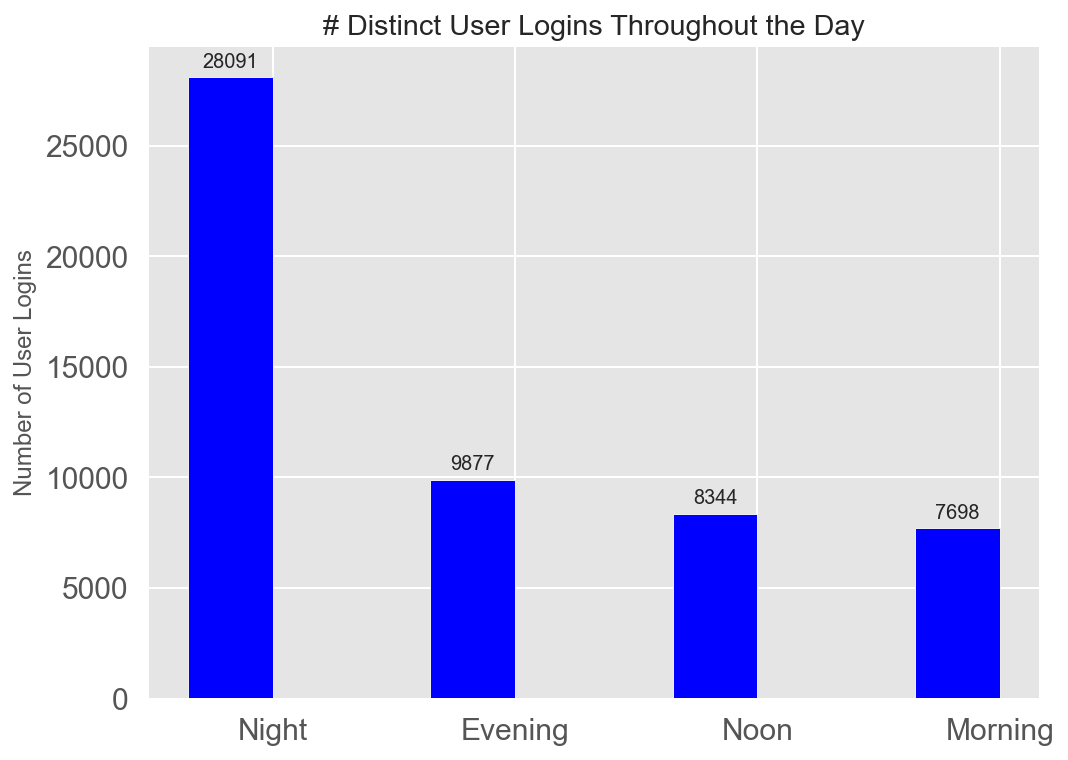

In [20]:
duration_login_data = user_room_data.groupby('Day_Duration')['user'].nunique()
x = duration_login_data.sort_values(ascending=False)
ind = np.arange(len(x))  # the x locations for the bars
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(ind - width / 2, x, width, label=x.index, color='blue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of User Logins')
ax.set_title('# Distinct User Logins Throughout the Day')
ax.set_xticks(ind)
ax.set_xticklabels((x.index))
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='x', which='major', labelrotation=0)


def autolabel(rects, xpos='center'):
    ha = {'center': 'center'}
    offset = {'center': 0}

    for rect in rects:
        height = rect.get_height()

        ax.annotate(
            '{}'.format(height),
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(offset[xpos] * 3, 3),  # use 3 points offset
            textcoords="offset points",  # in both directions
            ha=ha[xpos],
            va='bottom')


autolabel(rects1)
plt.show()

Now that we know that **Night** is the most popular time among the users to interat with the App on weekend, it wille interesting to look at this from the party room perspective. For instance, we can look at the hourly variation for the top 5 party rooms.

In [21]:
four_popular_room = pysqldf("SELECT room_name ,COUNT(DISTINCT user)\
                            AS user_cnt \
                           FROM user_room_data \
                           GROUP BY room_name \
                           ORDER BY user_cnt DESC LIMIT 4;")
four_popular_room

,room_name,user_cnt
0,Emilio's Room,1017
1,Azalea's Room,993
2,Frida's Room,963
3,Karter's Room,953


Now that we have identified top 4 party rooms, we will look at the hourly variation of user visits to these rooms. This can be achieved using following steps;

* For the top 4 rooms  identified above, we will compute the number of unique visitors at a given hour
* Next, compute the percentage of users visiting at that hour.

In [22]:
top4_hr_visits = user_room_data[user_room_data['room_name'] \
                                .isin (["Emilio's Room", \
                                "Azalea's Room","Frida's Room", \
                                "Karter's Room"])] \
                                .groupby(['room_name','hour']) \
                                ['user'].nunique()
top4_room = pd.DataFrame(top4_hr_visits)
top4_room.reset_index(inplace=True)

In [23]:
top4_room_cnt = pysqldf("SELECT room_name,hour,user,SUM(user) \
                       OVER(PARTITION BY room_name) AS total_cnt \
                       FROM top4_room;")
top4_room_cnt['Visit_pct']=((top4_room_cnt['user']\
                            /top4_room_cnt['total_cnt'])*100).round(2)

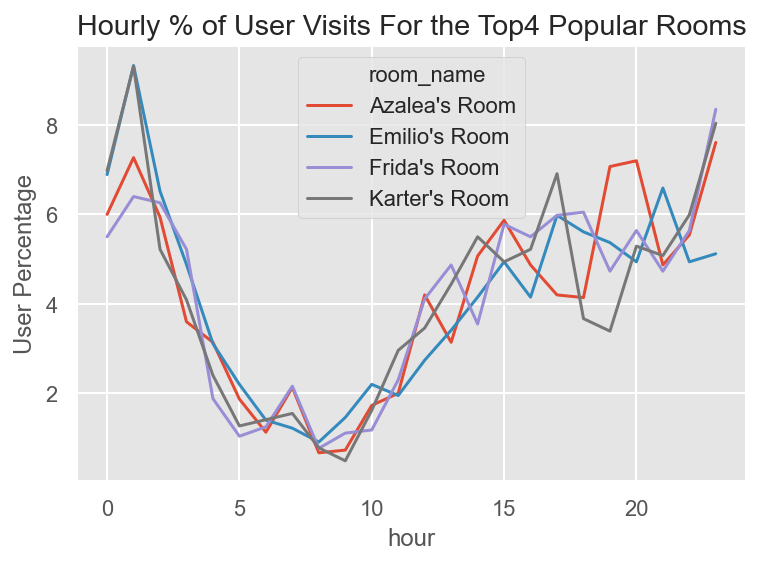

In [24]:
sns.lineplot(data=top4_room_cnt, x='hour', y='Visit_pct', hue='room_name')
plt.title("Hourly % of User Visits For the Top4 Popular Rooms")
plt.ylabel("User Percentage")
plt.show()

Going by the above plots, we do not see much difference in the rate of hourly visits for the most popular rooms. The shape aligns with the overall user percentage graph, which we saw earlier. The graph looks bit cluttered, but it contains useful information, hence it should be kept.

In the above few paragraphs; we explore the user engagement with the App, and made following observations;

* Approx. `40K` distinct users interacted with the App on this day
* The most poular time to interact with the App is Night.
* Four popular rooms include; Azalea's Room, Emilio's Room, Frida's Room, and Karter's Room.

### Room Characteristics

Now that we have got some intuition regarding the user behavior, we will next look into some possible traits of the rooms. One possible feature to explore is, what percentage of rooms are open throughout the day. This can be achieved by computing the time difference between the first and last login for each room.

In [25]:
room_data = pysqldf("SELECT room_name,MAX(time) AS last_login, \
                  MIN(time) AS first_login \
                  FROM user_room_data \
                  GROUP BY room_name;")

room_data['diff_hours'] = pd.to_datetime(room_data['last_login']) - \
                         pd.to_datetime(room_data['first_login'])
room_data['diff_hours'] = (room_data['diff_hours'] / np.timedelta64(1, 'h'))

room_data['Duration']=room_data['diff_hours'].\
                      apply(lambda x: '0-8' if \
                    (int(x) < 9 and int(x) >= 0)\
                    else('9-16' if (int(x)>=9 and \
                    int(x)<17) else('17-24')))
room_data.head(14)

,room_name,last_login,first_login,diff_hours,Duration
0,Aadhya's Arizona Cardinals Room,2018-01-28 19:35:20.000000,2018-01-28 01:17:36.000000,18.295556,17-24
1,Aadhya's Atlanta Braves Room,2018-01-27 21:03:57.000000,2018-01-27 21:03:57.000000,0.000000,0-8
2,Aadhya's Baltimore Ravens Room,2018-01-28 06:06:07.000000,2018-01-28 04:46:01.000000,1.335000,0-8
3,Aadhya's Finding Dory Room,2018-01-28 20:50:55.000000,2018-01-28 01:01:00.000000,19.831944,17-24
4,Aadhya's Minions Room,2018-01-28 19:59:15.000000,2018-01-28 12:19:42.000000,7.659167,0-8
5,Aadhya's Room,2018-01-28 20:11:52.000000,2018-01-28 01:48:39.000000,18.386944,17-24
6,Aadhya's Spider-Man: Homecoming Room,2018-01-28 01:39:59.000000,2018-01-28 01:39:59.000000,0.000000,0-8
7,Aadhya's The Lion King Room,2018-01-27 23:30:23.000000,2018-01-27 23:30:23.000000,0.000000,0-8
8,Aadhya's The Lord of the Rings: The Return of the King Room,2018-01-27 23:13:43.000000,2018-01-27 22:24:33.000000,0.819444,0-8
9,Aadhya's Transformers: Dark of the Moon Room,2018-01-27 23:44:42.000000,2018-01-27 23:44:42.000000,0.000000,0-8


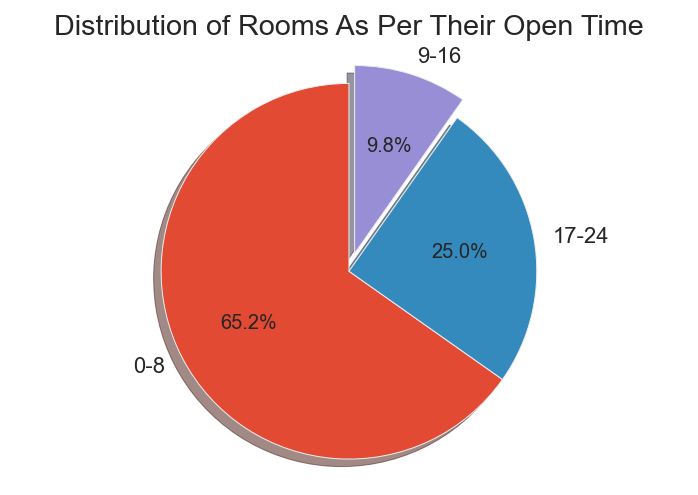

In [26]:
room_slice = pd.DataFrame(
    room_data.groupby(['Duration'])['room_name'].nunique())
room_slice.reset_index(inplace=True)
labels = room_slice['Duration']
sizes = room_slice['room_name']
explode = (0, 0, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes,
        explode=explode,
        labels=labels,
        autopct='%1.1f%%',
        shadow=True,
        startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Distribution of Rooms As Per Their Open Time")

plt.show()

 As per above pie graph, we see that, almost 25 percent of rooms were open petty much the whole day.
 
 As a follow-up, is it true that the rooms which are open for longest period of time(i.e. difference between first login and last login) have highest number of visitors. Or in other words, do we have linear correlation here? It can be checked using a scatter plot.

In [27]:
room_user_cnt = pysqldf("SELECT room_name, COUNT(DISTINCT user) AS user_cnt \
                     FROM user_room_data \
                     GROUP BY room_name;")

room_user_data = pysqldf("SELECT room_user_cnt.room_name,\
                          room_user_cnt.user_cnt,\
                         room_data.diff_hours \
                        FROM room_user_cnt \
                        JOIN room_data \
                       ON room_data.room_name=room_user_cnt.room_name;")
room_user_data.head(4)

,room_name,user_cnt,diff_hours
0,Aadhya's Arizona Cardinals Room,2,18.295556
1,Aadhya's Atlanta Braves Room,1,0.000000
2,Aadhya's Baltimore Ravens Room,2,1.335000
3,Aadhya's Finding Dory Room,13,19.831944


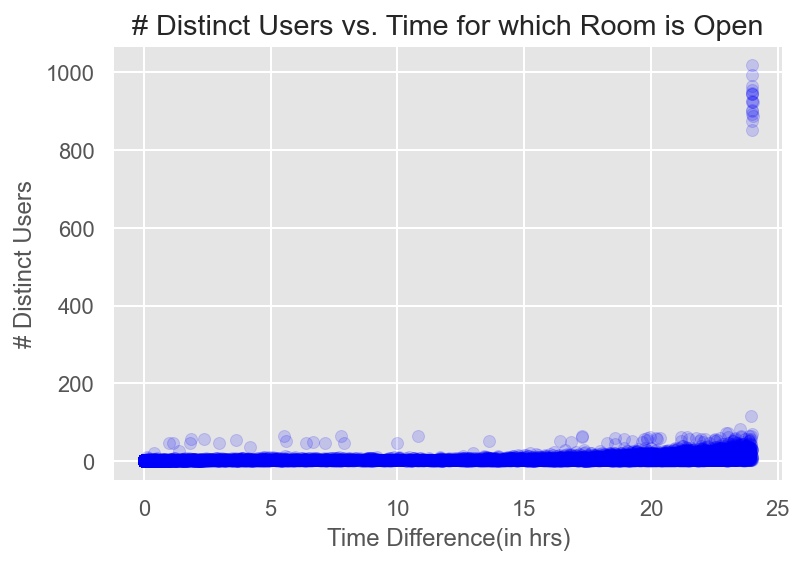

In [28]:
fig, ax = plt.subplots()  # Create a figure and an axes.
ax.scatter(room_user_data['diff_hours'],room_user_data['user_cnt'],color='blue',\
                alpha=0.15)
plt.title("# Distinct Users vs. Time for which Room is Open")
plt.xlabel("Time Difference(in hrs)")
plt.ylabel("# Distinct Users")
plt.show()

But we are not seeing much correlation here. Hence if a room is open for a very long time, it doesn't necessarily mean that it will have more number of visitors.

To wrap up the analysis of room characteristics, we will have a look at the room themes. Since we don't have explicit information regarding the themes, we will use wordcloud based on the room names. This is a workaround and may not reflect the actual themes.

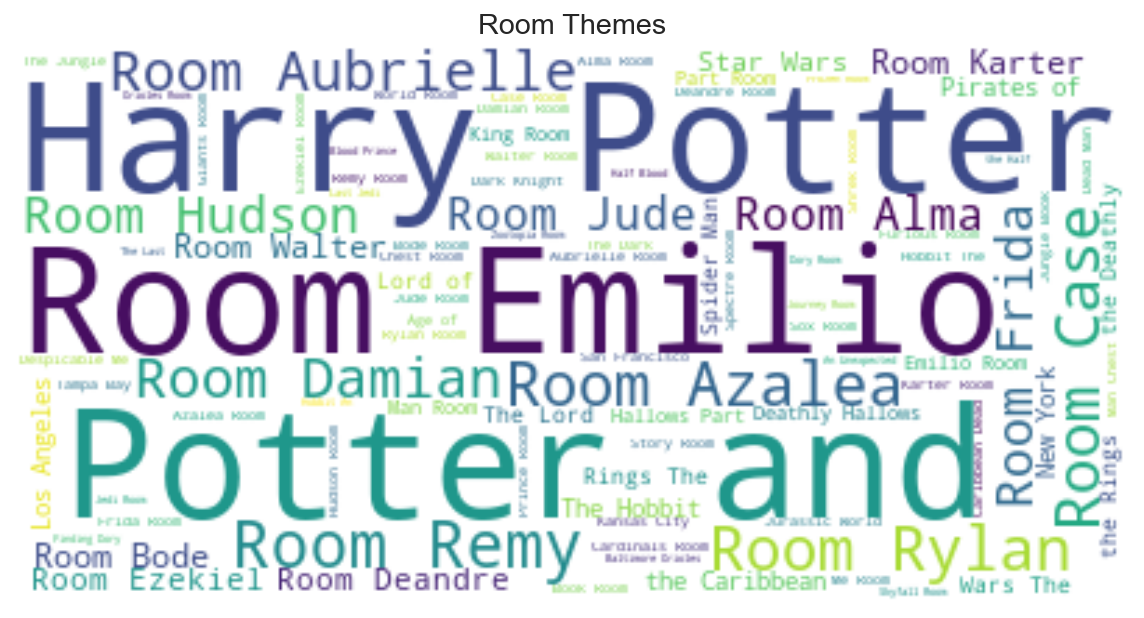

In [29]:
plt.figure(figsize=(10, 6))

plt.subplot()
room_theme = " ".join(room_name for room_name in user_room_data.room_name)
# Create and generate a word cloud image:
wordcloud = WordCloud(background_color='white').generate(room_theme)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Room Themes")
plt.axis("off")
plt.show()

The above wordcloud does not seem to be very informative, except that the users seem to be movie fans, primarily Harry Potter. But it can't be confirmed, since we don't know a lot about the naming process of the party rooms.

## Answers to Short Questions

* Which room had the most number of Distinct people entering it?

    - As per the data, Emilio's Room had the highest number of distinct users, with 1017 users entering it       throughout the day.
    
    - Query: SELECT room_name, COUNT(DISTINCT user) AS user_cnt FROM user_room_data GROUP BY room_name ORDER BY           user_cnt DESC LIMIT 1
    
    

* Calculate mean number of room entries per user over the day.

   - Approximately, one user has entered 7 rooms in the entire day. Note that we are counting every entry as a vist, regardless of the fact that it is a repeat visit to the same room.
   
   - Query: SELECT AVG(room_cnt) FROM (SELECT user, COUNT(room) AS room_cnt FROM user_room_data GROUP BY user \               ORDER BY room_cnt DESC) AS tab


* How many users went in at least 3 different rooms?

   - 9947 users visited at least 3 different users.
   
   - Query: SELECT COUNT(user) AS user_cnt FROM (SELECT user, COUNT(DISTINCT room) AS room_cnt FROM user_room_data                 GROUP BY user HAVING COUNT(DISTINCT room) >=3) AS tab
   
   

*  How many rooms were entered by at least 2 people in at least 12 distinct hours of the day?

    - 263 rooms were visited by at least 2 users in at least 12 different hours during the day.

    - Query: 
    
           - Query 1: room_hr_2users = SELECT room_name, hour, COUNT(DISTINCT user) AS usr_cnt \
                                       FROM user_room_data GROUP BY room_name, hour \
                                       HAVING COUNT(DISTINCT user) >=2
                         
           - Query 2: SELECT COUNT(room_name) FROM (SELECT room_name, COUNT(hour) AS hour_cnt \
                      FROM room_hr_2users GROUP BY room_name HAVING COUNT(hour) >= 12) AS tab1
                         
                         

## Summary and Further Work

To summarize, `40K` distinct users interacted with the App (i.e. visited party rooms) through Jan 27,2018 to Jan 28,2018. Out of these users, close to 25 percent of them went to at least 3 different rooms. These users can be classified as Power users. In order to test the beta features, it will be worthwhile testing these features on the Power users before rolling out to the wider population. Moreover, most of the rooms seem to be movie theme based, as per their names.

Further work should entail finding the session length (i.e. time spent in a party room) for the users. This will require information regarding Exit time also. Session length can be a very useful metric to measure the level of user's interest. Additionally, we should also look at Average Number of Daily Active Users(DAU) interacting with the App. DAU is widely regarded as a relevant KPI to assess User Engagement in an App. This will need at least a week of data to arrive at some conclusion. 